# カタカナ文字認識の学習サンプル

- 今回はシンプルなコードでニューラルネットワークを構築・学習できるkerasを使用する
- kerasはtensorflowの中に同梱されているため，別途インストールの必要はない
- kerasのドキュメント
  - https://keras.io/ja/ （日本語，一部未翻訳のため欠損あり） 
  - https://keras.io/ （英語）
- 使用できる層や最適化アルゴリズムはドキュメントから探してみよう

In [10]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


## データを読む

In [6]:
train_data = np.load("../1_data/train_data.npy")
train_label = np.load("../1_data/train_label.npy")
print("train_data.shape=", train_data.shape)
print("train_label.shape=", train_label.shape)

train_data.shape= (3000, 1, 28, 28)
train_label.shape= (3000, 15)


In [7]:
# 軸の入れ替え
train_data = train_data.transpose(0,2,3,1) # N H W Cにする
print(train_data.shape)

# 正規化
train_data = (train_data - train_data.min()) / train_data.max()
train_data = train_data.astype('float32')
print(train_data)
print()

(3000, 28, 28, 1)
[[[[0.99607843]
   [0.99607843]
   [0.99607843]
   ...
   [1.        ]
   [1.        ]
   [0.99607843]]

  [[0.99607843]
   [0.99607843]
   [0.99607843]
   ...
   [0.6901961 ]
   [1.        ]
   [1.        ]]

  [[0.99607843]
   [0.99607843]
   [0.99607843]
   ...
   [0.        ]
   [0.        ]
   [1.        ]]

  ...

  [[0.99607843]
   [0.99607843]
   [0.99607843]
   ...
   [0.99607843]
   [0.99607843]
   [0.99607843]]

  [[0.99607843]
   [0.99607843]
   [0.99607843]
   ...
   [0.99607843]
   [0.99607843]
   [0.99607843]]

  [[0.99607843]
   [0.99607843]
   [0.99607843]
   ...
   [0.99607843]
   [0.99607843]
   [0.99607843]]]


 [[[0.99607843]
   [0.99607843]
   [0.99607843]
   ...
   [0.99607843]
   [0.99607843]
   [0.99607843]]

  [[0.99607843]
   [0.99607843]
   [0.99607843]
   ...
   [0.99607843]
   [0.99607843]
   [0.99607843]]

  [[0.99607843]
   [0.99607843]
   [0.99607843]
   ...
   [0.99607843]
   [0.99607843]
   [0.99607843]]

  ...

  [[0.99607843]
   [0

## trainとtestに分割する（ホールドアウト法）

In [8]:
X_train, X_test, y_train, y_test = train_test_split(train_data, # 学習データ
                                                    train_label, # 教師データ
                                                    test_size=0.3, # 全体の何割をテスト用にするか
                                                    random_state=1234, # 乱数のシード値
                                                    shuffle=True # データセットを分ける前にシャッフルするかどうか
                                                   )

print(X_train.shape, X_test.shape)

(2100, 28, 28, 1) (900, 28, 28, 1)


## 学習

In [30]:
def onehot_to_str(label):
    """
    ワンホットベクトル形式のラベルをカタカナ文字に変換する
    """
    dic_katakana = {"a":0,"i":1,"u":2,"e":3,"o":4,"ka":5,"ki":6,"ku":7,"ke":8,"ko":9,"sa":10,"si":11,"su":12,"se":13,"so":14}
    label_int = np.argmax(label)
    for key, value in dic_katakana.items():
        if value==label_int:
            return key

# 画像読み込み
data = np.load("/home/tenkawa/jupyter/dl/DAY3_vr_1_0_0/1_data/train_data.npy")  # パスは適宜変更すること
label = np.load("/home/tenkawa/jupyter/dl/DAY3_vr_1_0_0/1_data/train_label.npy")  # パスは適宜変更すること
label = onehot_to_str(label)

# 軸をN,H,W,Cに入れ替え
data = data.transpose(0,2,3,1)

# 正規化
# train_data = (train_data - train_data.min()) / train_data.max()
# train_data = train_data.astype('float32')

x_train, x_test, y_train, y_test = train_test_split(train_data, # 学習データ
                                                    train_label, # 教師データ
                                                    test_size=0.3, # 全体の何割をテスト用にするか
                                                    random_state=1234, # 乱数のシード値
                                                    shuffle=True # データセットを分ける前にシャッフルするかどうか
                                                   )

print(x_train.shape, x_test.shape)




(2100, 28, 28, 1) (900, 28, 28, 1)


#### 畳み込みニューラルネットワークver.

In [44]:
batch_size = 32#128
num_classes = 15
epochs = 10

# input image dimensions
img_rows, img_cols = 28, 28

input_shape = (img_rows, img_cols, 1)

# モデルの定義
model = Sequential()

# 畳み込み層の定義
model.add(Conv2D(32, # フィルタ数
                 kernel_size=(3, 3), #フィルタサイズ
                 data_format="channels_last", #チャンネルの位置
                 activation='sigmoid', # 活性化関数
                 input_shape=input_shape # 入力画像の配列形式(一層目だけ指定しておけばよい)
                ))
# プーリング層の定義
model.add(MaxPooling2D(
                 pool_size=(2, 2) # フィルタサイズ
          ))
# 全結合層に入力するため，特徴マップをベクトル化する処理
model.add(Flatten())
# 全結合層の定義
model.add(Dense(128, activation='sigmoid'))
# 出力層の定義
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])

# モデルの内訳を表示する
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 5408)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               692352    
_________________________________________________________________
dense_21 (Dense)             (None, 15)                1935      
Total params: 694,607
Trainable params: 694,607
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/10
66/65 [==============================] - 3s 39ms/step - loss: 2.7367 - acc: 0.0619
Epoch 2/10
66/65 [==============================] - 2s 32ms/step - loss: 2.7207 - acc: 0.0686
Epoch 3/10
66/65 [==============================] - 2s 31ms/step - loss: 2.7211 - acc: 0.0638
Epoch 4/10
66/65 [==============================] - 2s 31ms/step - loss: 2.7197 - acc: 0.0657
Epoch 5/10
66/65 [==============================] - 2s 31ms/step - loss: 2.7201 - acc: 0.0571
Epoch 6/10
66/65 [==============================] - 2s 31ms/step - loss: 2.7227 - acc: 0.0638
Epoch 7/10
66/65 [==============================] - 2s 35ms/step - loss: 2.7223 - acc: 0.0595
Epoch 8/10
66/65 [==============================] - 2s 32ms/step - loss: 2.7205 - acc: 0.0567
Epoch 9/10
66/65 [==============================] - 2s 31ms/step - loss: 2.7191 - acc: 0.0624
Epoch 10/10
66/65 [==============================] - 2s 32ms/step - loss: 2.7196 - acc: 0.0629


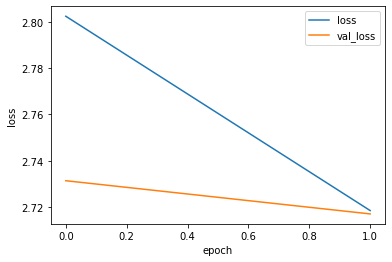

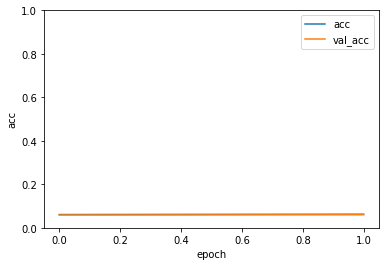

In [45]:
#計算の実行
# ImageDataGeneratorのオブジェクト生成
datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=1,
        zoom_range=1,
        horizontal_flip=False)

# fit = model.fit(x_train, y_train,
#           batch_size=batch_size,
#           epochs=epochs,
#           verbose=1,
#           validation_data=(x_test, y_test))
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(x_train)

# fits the model on batches with real-time data augmentation:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train) / batch_size, epochs=epochs)

# # here's a more "manual" example
# for e in range(epochs):
#     print('Epoch', e)
#     batches = 0
#     for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=batch_size):
#         model.fit(x_batch, y_batch)
#         batches += 1
#         if batches >= len(x_train) / 32:
#             # we need to break the loop by hand because
#             # the generator loops indefinitely
#             break

# # fits the model on batches with real-time data augmentation:
# model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size,
#                                  save_to_dir="../1_data/imagedatagenerator/",
#                                  save_format='png', save_prefix='out_a_from_png_'),
#                     steps_per_epoch=len(x_train) / batch_size, epochs=epochs)

# 保存
model.save("katakana_model.hdf5")

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()